In [1]:
#%% libraries
import os
import sys
import glob
import io
import itertools
import textract
import nltk
from nltk.corpus import stopwords
import string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# run for jupyter notebook
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

#### Wrappers for textract functions 

In [21]:
#%% reader functions
def pdf_to_txt(inpath, outpath):
    try:
        text = textract.process(inpath, method='pdftotext')
        base = os.path.abspath(inpath)
        wdir, fname = outpath, os.path.split(base)[1]
        writepath = wdir + '/' + fname.split('.')[0] + '.txt'

        with open(writepath, 'wb') as f:
            f.write(text)
    except:
        print(inpath, ' failed')
        pass
    
    
def read_pdf(inpath):
    text = textract.process(inpath, method='pdftotext')
    return text

#### utility functions

In [3]:
import math

def convert_size(size_bytes):
   if size_bytes == 0:
       return "0B"
   size_name = ("B", "KB", "MB", "GB", "TB", "PB", "EB", "ZB", "YB")
   i = int(math.floor(math.log(size_bytes, 1024)))
   p = math.pow(1024, i)
   s = round(size_bytes / p, 2)
   return "%s %s" % (s, size_name[i])

## Set working directory, Preliminaries

In [4]:
root = '/media/alal/LAL_DATA/Newspapers/The Kathmandu Post'
os.chdir(root)

#%% directories
input = root 
output = root + '/raw_txts/'

if not os.path.exists(output):
    os.makedirs(output)

%pwd()

'/media/alal/LAL_DATA/Newspapers/The Kathmandu Post'

*Construct list of files from all subdirectories, store file sizes in dictionary*

In [5]:
pdfs = []
sizes = {}

for root, dirs, files in os.walk(input):
    for file in files:
        if file.endswith(".pdf") and file[0] != '.':
            ff = os.path.join(root, file)
            pdfs.append(ff)
            size = os.path.getsize(ff) # in bytes
            sizes[file] = size

'1010.07 KB'

'395.38 MB'

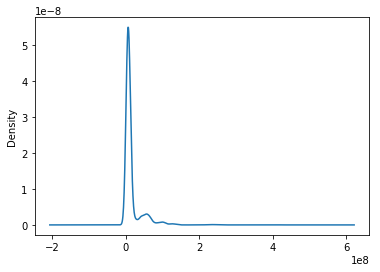

In [6]:
ser = pd.Series(sizes)
ser.plot.density()
convert_size(ser.min())
convert_size(ser.max())

## Bulk convert all pdfs in root - only run once
### Runtime ~= 30 mins

*bulk convert, experimenting with embarrasingly parallel execution*

In [19]:
from joblib import Parallel, delayed
import multiprocessing
num_cores = multiprocessing.cpu_count()

In [22]:
%%time
results = Parallel(n_jobs=num_cores)(delayed(pdf_to_txt)(p,output) \
                                     for p in pdfs)

/media/alal/LAL_DATA/Newspapers/The Kathmandu Post/2010/TKP_2010_01_18.pdf  failed
/media/alal/LAL_DATA/Newspapers/The Kathmandu Post/2010/TKP_2010_04_15.pdf  failed
/media/alal/LAL_DATA/Newspapers/The Kathmandu Post/2010/TKP_2010_05_22.pdf  failed
/media/alal/LAL_DATA/Newspapers/The Kathmandu Post/2010/TKP_2010_06_12.pdf  failed
/media/alal/LAL_DATA/Newspapers/The Kathmandu Post/2014/TKP_2014_12_24.pdf  failed
/media/alal/LAL_DATA/Newspapers/The Kathmandu Post/2015/TKP_2015_01_07.pdf  failed
/media/alal/LAL_DATA/Newspapers/The Kathmandu Post/2015/TKP_2015_01_16.pdf  failed
/media/alal/LAL_DATA/Newspapers/The Kathmandu Post/2015/TKP_2015_03_14.pdf  failed
/media/alal/LAL_DATA/Newspapers/The Kathmandu Post/2015/TKP_2015_08_31.pdf  failed
/media/alal/LAL_DATA/Newspapers/The Kathmandu Post/2015/TKP_2015_10_01.pdf  failed
/media/alal/LAL_DATA/Newspapers/The Kathmandu Post/2016/TKP_2016_01_06.pdf  failed
/media/alal/LAL_DATA/Newspapers/The Kathmandu Post/2016/TKP_2016_01_09.pdf  failed
/med

## Construct word frequencies and write dataframes

In [7]:
# pick file, remove punctuation and stopwords
tmp = '/home/alal/tmp'
inp = root + '/raw_txts'
out = root + '/word_frequencies/'

if not os.path.exists(out):
    os.makedirs(out)

In [8]:
def write_word_freqs(inputfile,outdir):
    filterout= set(stopwords.words('english')+
               list(string.punctuation)+
               ['\'\'','``','\'s','’',"“","”",
                'the','said','nepal','world','kathmandu'])
    cols = ['word','freq']

    base = os.path.abspath(inputfile)
    wdir, fname = outdir, os.path.split(base)[1]
    writepath = wdir + '/wfreqs_' + fname.split('.')[0] + '.csv'

    f = open(inputfile)
    raw = f.read()
    tokens = [token.lower() for token in nltk.word_tokenize(raw)]
    cleaned = [token for token in tokens if token not in filterout]
    
    fdict = dict(nltk.FreqDist(cleaned))
    df = pd.DataFrame(list(fdict.items()),columns=cols)
    df = df.sort_values('freq',ascending=0)
    
    df.to_csv(writepath,columns=['word','freq'])

In [9]:
# pick file, remove punctuation and stopwords
tmp = '/home/alal/tmp'
inp = root + 'raw_txts'
out = root + '/sentences/'

if not os.path.exists(out):
    os.makedirs(out)

**sentence splitter relies on nltk data**

run 
```{python}
nltk.download()
```

and select 'all packages' (3 GB download to `/home/<user>/` ) 


In [12]:
nltk.data.path.append('/media/alal/LAL_DATA/Newspapers/nltk_data')

In [13]:
def write_sentences(inputfile,outdir):
    base = os.path.abspath(inputfile)
    wdir, fname = outdir, os.path.split(base)[1]
    writepath = wdir + '/sentences_' + fname.split('.')[0] + '.txt'

    f = open(inputfile)
    raw = f.read()
    string = raw.replace('\n'," ")
    sentences = [token.lower() for token in nltk.tokenize.sent_tokenize(string)]

    outF = open(writepath, "w")
    sentences = map(lambda x: x+"\n", sentences)

    outF.writelines(sentences)
    outF.close()


## Parallelize execution of word-counter function

In [37]:
files = glob.glob(inp+'/TKP_*.txt')

In [20]:
from joblib import Parallel, delayed
import multiprocessing
num_cores = multiprocessing.cpu_count()

In [10]:
%%time
results = Parallel(n_jobs=num_cores)(delayed(write_word_freqs)(i,out) \
                                     for i in files)

CPU times: user 976 ms, sys: 96 ms, total: 1.07 s
Wall time: 4min 37s


## Parallelize execution of sentence splitter 

In [44]:
files = glob.glob(inp+'/TKP_*.txt')

In [45]:
from joblib import Parallel, delayed
import multiprocessing
num_cores = multiprocessing.cpu_count()

In [46]:
%%time
results = Parallel(n_jobs=num_cores)(delayed(write_sentences)(i,out) \
                                     for i in files)

CPU times: user 255 ms, sys: 44.4 ms, total: 299 ms
Wall time: 1min 6s
